In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as patches
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install numpy-hilbert-curve

  Preparing metadata (setup.py) ... done
  Created wheel for numpy-hilbert-curve: filename=numpy_hilbert_curve-1.0.1-py3-none-any.whl size=6937 sha256=16b6fcc25477430f26ea93e93f660e63960aa5a9b8296b90c47e2e8d07add9d2
  Stored in directory: /root/.cache/pip/wheels/25/bc/96/2f9acf95bcd2ff7f2a68eae0067ecef5c29a64cb9e44e30208
Successfully built numpy-hilbert-curve


In [ ]:
#cd /content/drive/MyDrive/SportsData/Football-LLM

/content/drive/MyDrive/SportsData/Football-LLM


In [ ]:
#!git config --global user.email 'csm010311@naver.com'
#!git config --global user.name 'Csenongmin'
#!git add FootballGrid.ipynb

In [ ]:
#!git commit -m 'make available this file to be imported in .ipynb'
#!git push

[main d371d0d] make available this file to be imported in .ipynb
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite FootballGrid.ipynb (84%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 684 bytes | 62.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Csenongmin/Football-LLM.git
   76784f8..d371d0d  main -> main


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

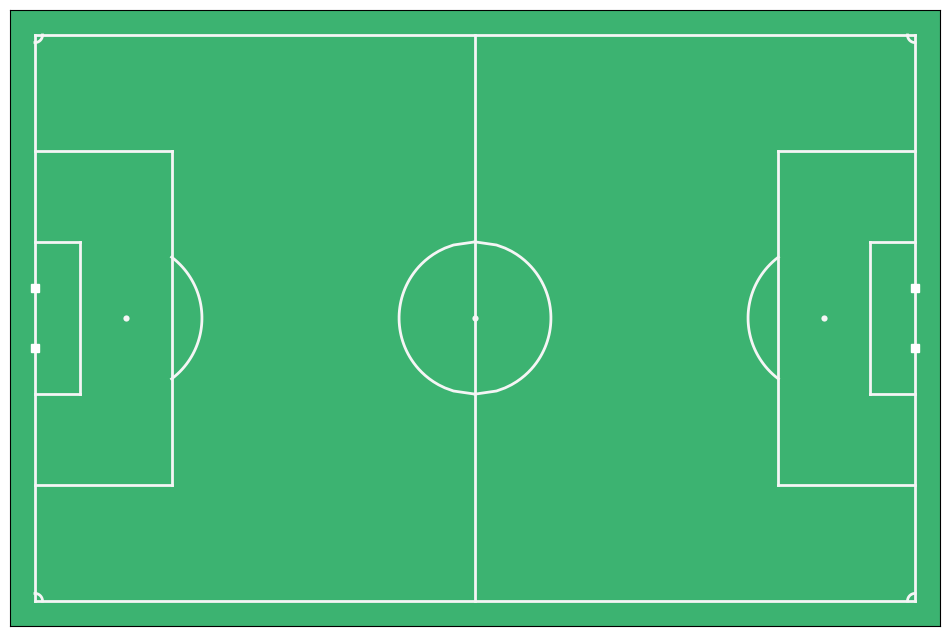

In [ ]:
def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    """ plot_pitch

    Plots a soccer pitch. All distance units converted to meters.

    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20

    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1]
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)

    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax
"""
plot_pitch()
"""

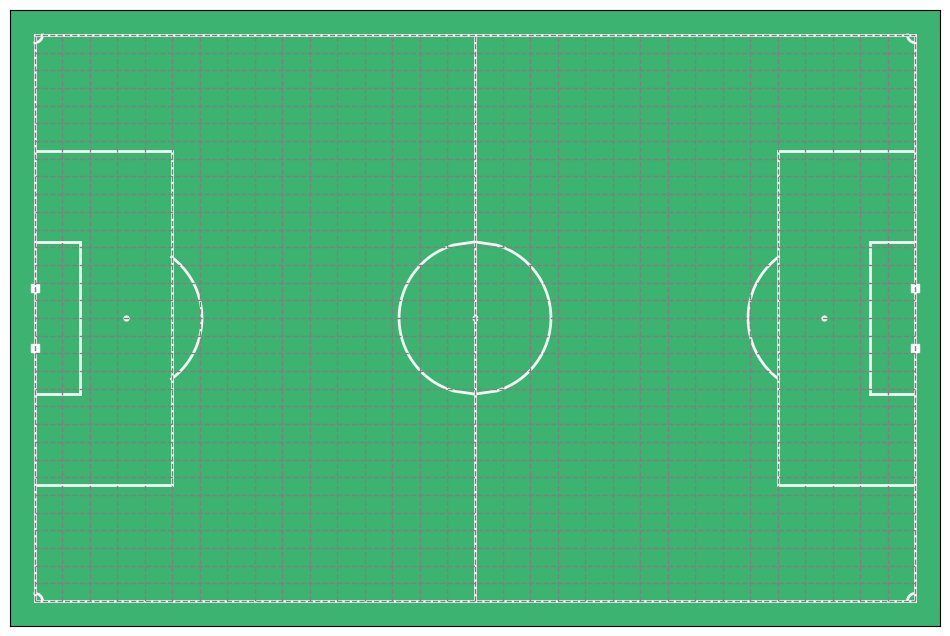

In [ ]:
def plot_pitch_with_grid(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """
    Plots a soccer pitch with an optional grid overlay. Divides the pitch into 64 equal sections.
    """

    fig, ax = plot_pitch(field_dimen, field_color, linewidth, markersize)

    # 축구장의 전체 크기 가져오기
    pitch_length, pitch_width = field_dimen

    # 축구장을 32 x 32로 나누기 위한 선 그리기
    num_divisions = 32
    x_divisions = np.linspace(-pitch_length / 2, pitch_length / 2, num_divisions + 1)
    y_divisions = np.linspace(-pitch_width / 2, pitch_width / 2, num_divisions + 1)

    # 격자 선 그리기
    for x in x_divisions:
        ax.plot([x, x], [-pitch_width / 2, pitch_width / 2], 'gray', linestyle='--', linewidth=1)

    for y in y_divisions:
        ax.plot([-pitch_length / 2, pitch_length / 2], [y, y], 'gray', linestyle='--', linewidth=1)

    return fig, ax
"""
# 축구장과 격자를 그리기
plot_pitch_with_grid()
plt.show()
"""

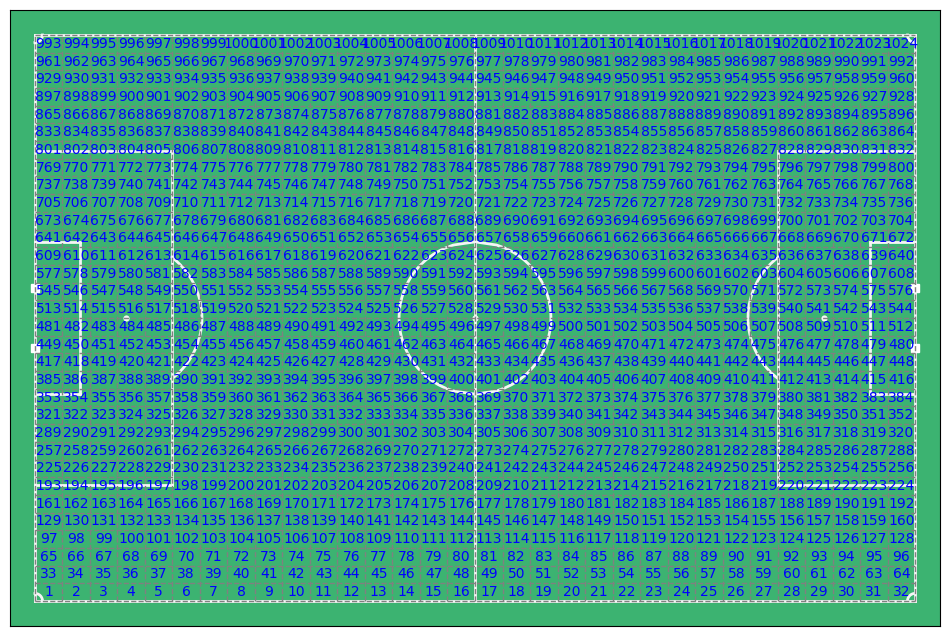

(<Figure size 1200x800 with 1 Axes>, <Axes: >, [[-51.34375, -32.9375, 1], [-48.03125, -32.9375, 2], [-44.71875, -32.9375, 3], [-41.40625, -32.9375, 4], [-38.09375, -32.9375, 5], [-34.78125, -32.9375, 6], [-31.46875, -32.9375, 7], [-28.15625, -32.9375, 8], [-24.84375, -32.9375, 9], [-21.53125, -32.9375, 10], [-18.21875, -32.9375, 11], [-14.90625, -32.9375, 12], [-11.59375, -32.9375, 13], [-8.28125, -32.9375, 14], [-4.96875, -32.9375, 15], [-1.65625, -32.9375, 16], [1.65625, -32.9375, 17], [4.96875, -32.9375, 18], [8.28125, -32.9375, 19], [11.59375, -32.9375, 20], [14.90625, -32.9375, 21], [18.21875, -32.9375, 22], [21.53125, -32.9375, 23], [24.84375, -32.9375, 24], [28.15625, -32.9375, 25], [31.46875, -32.9375, 26], [34.78125, -32.9375, 27], [38.09375, -32.9375, 28], [41.40625, -32.9375, 29], [44.71875, -32.9375, 30], [48.03125, -32.9375, 31], [51.34375, -32.9375, 32], [-51.34375, -30.8125, 33], [-48.03125, -30.8125, 34], [-44.71875, -30.8125, 35], [-41.40625, -30.8125, 36], [-38.09375,

In [ ]:

def plot_pitch_with_numbers(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    fig, ax = plot_pitch_with_grid(field_dimen, field_color, linewidth, markersize)
    row_wise_index = []
    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # 번호를 격자 중심에 표시
    number = 1
    for i in range(num_divisions):
        for j in range(num_divisions):
            x = -pitch_length / 2 + (j + 0.5) * cell_length
            y = -pitch_width / 2 + (i + 0.5) * cell_width
            ax.text(x, y, str(number), color='blue', fontsize=10, ha='center', va='center')
            row_wise_index.append([x,y,number])
            number += 1

    return fig, ax, row_wise_index
"""
# Plot pitch with sequential numbering
row_wise_index = plot_pitch_with_numbers()
plt.show()
"""

In [ ]:
from hilbert import decode, encode
"""
# Turn an ndarray of Hilber integers into locations.
# 2 is the number of dimensions, 3 is the number of bits per dimension
arr = np.arange(16) #32*32
locs = decode(arr, 2, 2)

print(locs)
# prints [[0 1]
#         [1 1]
#         [1 0]]

# You can go the other way also, of course.
H = encode(locs, 2, 2)

print(H)
for i,point in enumerate(locs):
    print(f"Point {i}: {point}")
# prints array([1, 2, 3], dtype=uint64)
"""

[[0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 2]
 [0 3]
 [1 3]
 [1 2]
 [2 2]
 [2 3]
 [3 3]
 [3 2]
 [3 1]
 [2 1]
 [2 0]
 [3 0]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Point 0: [0 0]
Point 1: [1 0]
Point 2: [1 1]
Point 3: [0 1]
Point 4: [0 2]
Point 5: [0 3]
Point 6: [1 3]
Point 7: [1 2]
Point 8: [2 2]
Point 9: [2 3]
Point 10: [3 3]
Point 11: [3 2]
Point 12: [3 1]
Point 13: [2 1]
Point 14: [2 0]
Point 15: [3 0]


## 힐버트 곡선

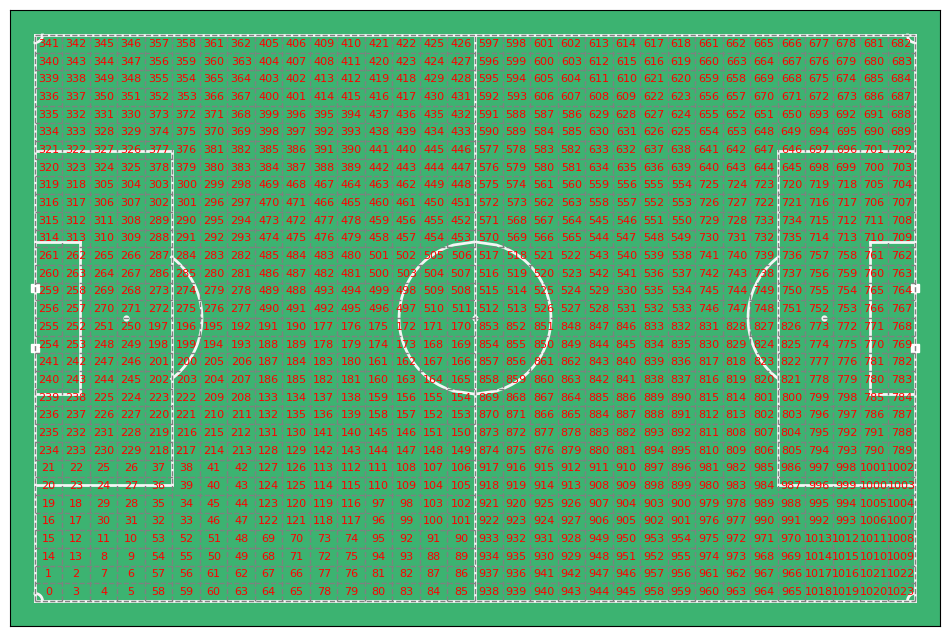

In [ ]:

def plot_pitch_with_hilbert_labels(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """Plots a soccer pitch and overlays Hilbert Curve-based numbering on it."""
    fig, ax = plot_pitch_with_grid(field_dimen, field_color, linewidth, markersize)
    hilbert_index = []
    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Hilbert Curve 좌표 생성
    arr = np.arange(1024) #32*32
    locs = decode(arr, 2, 5)

    for i, point in enumerate(locs):
      x, y = point
      x_coord = -pitch_length / 2 + (x + 0.5) * cell_length
      y_coord = -pitch_width / 2 + (y + 0.5) * cell_width
      ax.text(x_coord, y_coord, i, color='red', fontsize=8, ha='center', va='center')
      hilbert_index.append([x_coord,y_coord,i])

    return fig, ax, hilbert_index
"""
# Plot pitch with Hilbert Curve numbering
hilbert_index = plot_pitch_with_hilbert_labels()
plt.show()
"""



## z-order



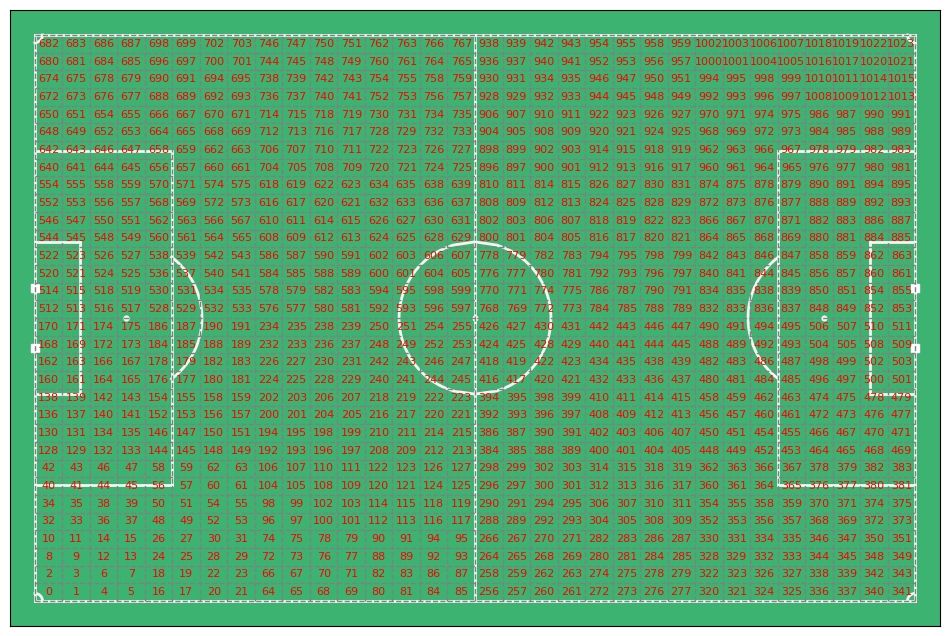

In [ ]:

def z_order(x, y, n):
    """
    Generate Z-order (Morton order) with a preference for x-coordinate.
    This version prioritizes x over y for numbering.
    """
    z = 0
    for i in range(n):
        # 먼저 x의 비트를 interleave, y는 뒤에 결합
        z |= (x & 1) << (2 * i)   # x의 비트를 interleave
        z |= (y & 1) << (2 * i + 1)  # y의 비트를 interleave
        x >>= 1  # x를 오른쪽으로 쉬프트
        y >>= 1  # y를 오른쪽으로 쉬프트
    return z

def z_order_2(x, y, n):
    """
    Generate Z-order (Morton order) for a 2D grid of size 2^n x 2^n.
    """
    z = 0
    for i in range(n):
        z |= (x & 1) << (2 * i + 1)  # x의 비트를 interleave
        z |= (y & 1) << (2 * i)      # y의 비트를 interleave
        x >>= 1  # x를 오른쪽으로 쉬프트
        y >>= 1  # y를 오른쪽으로 쉬프트
    return z

def plot_pitch_with_z_order(field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """Plots a soccer pitch and overlays Z-order-based numbering on it."""
    fig, ax = plot_pitch_with_grid(field_dimen, field_color, linewidth, markersize)
    z_order_index = []
    # 축구장의 전체 크기
    pitch_length, pitch_width = field_dimen
    num_divisions = 32
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Z-order 좌표 생성
    n = 5  # 2^5 = 32x32 격자
    z_order_coords = [(x, y) for x in range(2 ** n) for y in range(2 ** n)]
    z_order_indices = [z_order(x, y, n) for x, y in z_order_coords]

    # Z-order 순서대로 번호를 표시
    for i, (z_idx, (x, y)) in enumerate(sorted(zip(z_order_indices, z_order_coords))):
        # Normalize Z-order coordinates to match pitch dimensions
        x_coord = -pitch_length / 2 + (x + 0.5) * cell_length
        y_coord = -pitch_width / 2 + (y + 0.5) * cell_width

        # 번호를 격자 중심에 표시
        ax.text(x_coord, y_coord, str(i), color='red', fontsize=8, ha='center', va='center')
        z_order_index.append([x_coord,y_coord,i])

    return fig, ax, z_order_index
"""
# Plot pitch with Z-order numbering
z_order_index = plot_pitch_with_z_order()
plt.show()
"""


In [ ]:
def get_z_order_index_normalized(x, y, field_dimen=(106.0, 68.0), num_divisions=32):
    """
    Get the Z-order (Morton order) index for normalized (x, y) input (0~1 range).

    Parameters:
    -----------
        x, y : float
            Normalized (x, y) coordinates on the pitch, where 0 <= x, y <= 1.
        field_dimen : tuple
            The dimensions of the field (length, width) in meters. Default is (106.0, 68.0).
        num_divisions : int
            Number of divisions per axis for the grid. Default is 32 (32 x 32 grid).

    Returns:
    --------
        int
            The Z-order index corresponding to the (x, y) position.
    """
    pitch_length, pitch_width = field_dimen
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Scale normalized coordinates to actual field dimensions
    x_meters = x * pitch_length - pitch_length / 2
    y_meters = y * pitch_width - pitch_width / 2

    # Normalize x and y to grid indices
    grid_x = int((x_meters + pitch_length / 2) // cell_length)
    grid_y = int((y_meters + pitch_width / 2) // cell_width)

    # Ensure grid_x and grid_y are within bounds
    grid_x = max(0, min(grid_x, num_divisions - 1))
    grid_y = max(0, min(grid_y, num_divisions - 1))

    # Calculate Z-order index
    n = int(np.log2(num_divisions))  # n = 5 for 32x32 grid
    z_index = z_order(grid_x, grid_y, n)
    return z_index, (x_meters, y_meters)


In [ ]:
def get_order(x, y, index_list, field_dimen=(106.0, 68.0), num_divisions=32):
    """
    Find the index of the space in which the given (x, y) coordinates lie.

    Parameters:
    -----------
        x, y : float
            Normalized (x, y) coordinates on the pitch, where 0 <= x, y <= 1.
        another_index : list
            List of [x_center, y_center, index], where each sublist defines the center
            of a cell and its associated index.
        field_dimen : tuple
            The dimensions of the field (length, width) in meters. Default is (106.0, 68.0).
        num_divisions : int
            Number of divisions per axis for the grid. Default is 32 (32 x 32 grid).

    Returns:
    --------
        int
            The index of the space containing the given coordinates, or None if not found.
    """
    pitch_length, pitch_width = field_dimen
    cell_length = pitch_length / num_divisions
    cell_width = pitch_width / num_divisions

    # Scale normalized coordinates to actual field dimensions
    x_meters = x * pitch_length - pitch_length / 2
    y_meters = y * pitch_width - pitch_width / 2

    # Iterate over the cells in another_index
    for cell_x, cell_y, index in index_list:
        # Calculate the bounding box for the cell
        x_min = cell_x - cell_length / 2
        x_max = cell_x + cell_length / 2
        y_min = cell_y - cell_width / 2
        y_max = cell_y + cell_width / 2

        # Check if the given point lies within this cell
        if x_min <= x_meters < x_max and y_min <= y_meters < y_max:
            return index

    return None  # If no matching cell is found


In [ ]:
"""
# Normalized coordinates
x_norm, y_norm = 0.77, 0.21

# Find the corresponding index
# Get the Z-order index and actual field coordinates
z_result, (x_meters, y_meters) = get_z_order_index_normalized(x_norm, y_norm)

print(f"Normalized coordinates: ({x_norm}, {y_norm})")
print(f"Actual field coordinates: ({x_meters:.2f}, {y_meters:.2f})")
print(f"Z-order index for ({x_norm}, {y_norm}): {z_result}")

# use get_order function to each indexing list
z_index = get_order(x_norm, y_norm, z_order_index)
print(f"Z-order index for ({x_norm}, {y_norm}): {z_index}")
h_result = get_order(x_norm, y_norm, hilbert_index)
print(f"Hilbert Index for ({x_norm}, {y_norm}): {h_result}")
r_result = get_order(x_norm, y_norm, row_wise_index)
print(f"Row-wise Index for ({x_norm}, {y_norm}): {r_result}")
"""

Normalized coordinates: (0.77, 0.21)
Actual field coordinates: (28.62, -19.72)
Z-order index for (0.77, 0.21): 360
Z-order index for (0.77, 0.21): 360
Hilbert Index for (0.77, 0.21): 980
Row-wise Index for (0.77, 0.21): 217
